<a href="https://colab.research.google.com/github/DavisRayM/msft-stock-prediction/blob/main/msft-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

Author: Davis Muro

For CPSC 5610

Microsoft Stock Prediction

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Input, BatchNormalization, Layer
from tensorflow.keras.callbacks import EarlyStopping
from typing import Tuple, List

In [2]:
np.random.seed(25)
tf.random.set_seed(25)

## Preprocessing

In [3]:
df = pd.read_csv('data/MSFT.csv', parse_dates=['Date'], index_col='Date')

# Sort dataframe by `Date` (Ascending)
df.sort_index(inplace=True)

# Drop Adj Close
df.drop(columns=['Adj Close'], inplace=True)

df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,59.779999,60.520000,59.779999,60.419998,31664800
2016-11-08,60.549999,60.779999,60.150002,60.470001,22935400
2016-11-09,60.000000,60.590000,59.200001,60.169998,49632500
2016-11-10,60.480000,60.490002,57.630001,58.700001,57822400
2016-11-11,58.230000,59.119999,58.009998,59.020000,38767800


In [4]:
df['Open'].max(), df['High'].max(), df['Low'].max(), df['Close'].max(), df['Volume'].max()

(338.51001, 338.790009, 334.420013, 336.440002, 111242100)

In [5]:
df.shape

(1259, 5)

In [6]:
scaler = MinMaxScaler()
volume_scaler = MinMaxScaler()
features = ['Open', 'High', 'Low', 'Close', 'Volume']

def scale_features(df):
  df = df.copy(deep=True)

  df[features[:4]] = scaler.fit_transform(df[features[:4]])
  df[features[4:]] = volume_scaler.fit_transform(df[features[4:]])

  return df

normalized = scale_features(df)
normalized.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,0.005530,0.005148,0.009021,0.008264,0.233481
2016-11-08,0.008277,0.006078,0.010356,0.008444,0.149396
2016-11-09,0.006315,0.005398,0.006928,0.007366,0.406553
2016-11-10,0.008028,0.005041,0.001263,0.002084,0.485441
2016-11-11,0.000000,0.000143,0.002634,0.003234,0.301900


In [7]:
normalized['Open'].max(), normalized['High'].max(), normalized['Low'].max(), normalized['Close'].max(), normalized['Volume'].max()

(1.0, 1.0, 0.9999999999999999, 1.0, 1.0)

In [8]:
normalized.shape

(1259, 5)

## Windowing

In [9]:
train_size = normalized.shape[0] * 90 // 100
test_size = normalized.shape[0] - train_size
train_size, test_size

(1133, 126)

In [10]:
def window(df, n_steps, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(df)
    ds = ds.window(n_steps + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(n_steps + 1))
    ds = ds.map(lambda window: (window[:-1], window[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [11]:
timesteps = 20
batch_size = 32

train = window(normalized[:train_size], timesteps, batch_size)
for (X, y) in train.take(1):
  print(f"X Shape: {X.shape}, Y Shape: {y.shape}")
train

X Shape: (32, 20, 5), Y Shape: (32, 5)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [12]:
test = window(normalized[train_size:], timesteps, batch_size)

for X_batch, y_batch in test.take(1):
  print(f"X Shape: {X.shape}, Y Shape: {y.shape}")
test

X Shape: (32, 20, 5), Y Shape: (32, 5)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Modelling

In [13]:
class BatchNormSimpleRNN(Layer):
    def __init__(self, units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.simple_rnn = SimpleRNN(
            units,
            activation=None,
            return_sequences=return_sequences,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            **kwargs
        )
        self.batch_norm = BatchNormalization()
        self.activation_fn = activations.get(activation)

    def call(self, inputs, training=None):
        x = self.simple_rnn(inputs, training=training)
        x = self.batch_norm(x, training=training)
        return self.activation_fn(x)

In [14]:
def create_model(kind: str = "simple", input_shape: Tuple[int, int] = (timesteps, 5), neurons: int = 64):
  model = tf.keras.models.Sequential()
  model.add(Input(shape=input_shape))

  if kind == "simple":
    model.add(BatchNormSimpleRNN(neurons, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  elif kind == "lstm":
    model.add(LSTM(neurons, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  elif kind == "gru":
    model.add(GRU(neurons, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  else:
    assert False, "Unsupported kind: " + kind

  model.add(Dense(input_shape[1]))
  model.compile(loss="mse", optimizer="adam", metrics=["mae"])
  return model

In [15]:
early_stopping = EarlyStopping(
    monitor='val_mae',
    patience=3,
    restore_best_weights=True
)

epochs = 30

### Simple RNN

Uses SimpleRNN + Batch normalization layers with 1 hidden layer.

In [16]:
simple = create_model(kind="simple")
simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_norm_simple_rnn           │ (None, 64)             │         4,736 │
│ (BatchNormSimpleRNN)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 4,933 (19.27 KB)

 Non-trainable params: 128 (512.00 B)

In [17]:
simple.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping])

Epoch 1/30
     33/Unknown 9s 14ms/step - loss: 0.3494 - mae: 0.4466

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.3421 - mae: 0.4416 - val_loss: 1.0073 - val_mae: 0.9169
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1086 - mae: 0.2510 - val_loss: 0.6560 - val_mae: 0.7324
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0830 - mae: 0.2285 - val_loss: 0.4511 - val_mae: 0.6044
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0732 - mae: 0.2204 - val_loss: 0.4428 - val_mae: 0.6078
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0717 - mae: 0.2217 - val_loss: 0.3588 - val_mae: 0.5527
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0618 - mae: 0.2062 - val_loss: 0.2786 - val_mae: 0.4860
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0549 - mae: 0.1964 - val_loss: 0.2480 - val_mae: 0.4591
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0436 - mae: 0.1741 - val_loss: 0.2391 - val_mae: 0.4514
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0379 - mae: 0.

In [18]:
result = pd.DataFrame(simple.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.262212,0.386154,1.007289,0.916918
1,0.112538,0.254895,0.655958,0.732403
2,0.084344,0.226280,0.451109,0.604424
3,0.074884,0.217327,0.442849,0.607803
4,0.068771,0.211901,0.358828,0.552689


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

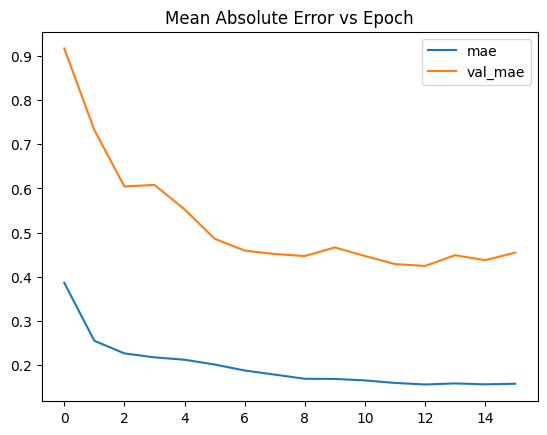

In [19]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

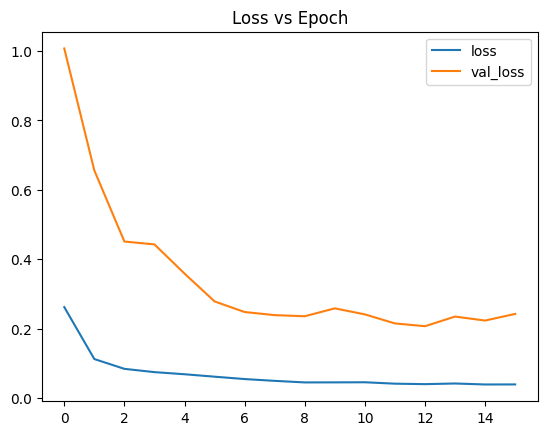

In [20]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

### GRU Model

Uses a GRU layer with one hidden layer.

In [21]:
gru = create_model(kind="gru")
gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,957 (54.52 KB)

 Trainable params: 13,957 (54.52 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
gru.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping])

Epoch 1/30
     33/Unknown 7s 29ms/step - loss: 0.0049 - mae: 0.0488

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0053 - mae: 0.0501 - val_loss: 0.0160 - val_mae: 0.1199
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0169 - mae: 0.1081 - val_loss: 0.0029 - val_mae: 0.0449
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0111 - mae: 0.0906 - val_loss: 0.0058 - val_mae: 0.0643
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0063 - mae: 0.0611 - val_loss: 0.0085 - val_mae: 0.0855
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0044 - mae: 0.0510 - val_loss: 0.0073 - val_mae: 0.0798


In [23]:
result = pd.DataFrame(gru.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.008780,0.065461,0.016003,0.119911
1,0.014115,0.094408,0.002897,0.044888
2,0.012086,0.086430,0.005802,0.064266
3,0.009265,0.070437,0.008537,0.085451
4,0.008504,0.066460,0.007319,0.079822


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

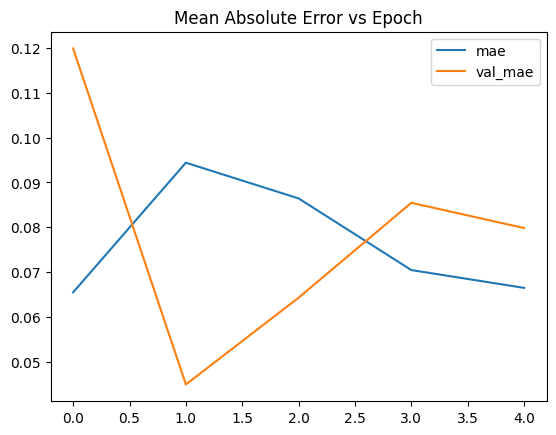

In [24]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

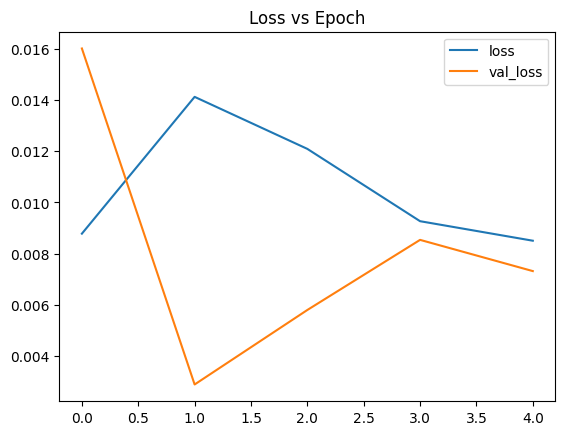

In [25]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

### LSTM

Uses LSTM layers with 1 hidden layer.

In [26]:
lstm = create_model(kind="lstm")
lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,245 (71.27 KB)

 Trainable params: 18,245 (71.27 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
lstm.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping])

Epoch 1/30
     34/Unknown 7s 53ms/step - loss: 0.0062 - mae: 0.0573

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0063 - mae: 0.0580 - val_loss: 0.0152 - val_mae: 0.1165
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0157 - mae: 0.1030 - val_loss: 0.0116 - val_mae: 0.0925
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0075 - mae: 0.0716 - val_loss: 0.0054 - val_mae: 0.0603
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0068 - mae: 0.0693 - val_loss: 0.0065 - val_mae: 0.0694
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0047 - mae: 0.0491 - val_loss: 0.0048 - val_mae: 0.0603
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0044 - mae: 0.0465 - val_loss: 0.0038 - val_mae: 0.0507
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0056 - mae: 0.0518 - val_loss: 0.0056 - val_mae: 0.0674
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0040 - mae: 0.0431 - val_loss: 0.0067 - val_mae: 0.0753
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0039 - mae: 0.

In [28]:
result = pd.DataFrame(lstm.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.009080,0.070370,0.015182,0.116509
1,0.013705,0.089481,0.011633,0.092546
2,0.009175,0.072455,0.005449,0.060311
3,0.008276,0.069663,0.006467,0.069414
4,0.008247,0.064674,0.004758,0.060277


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

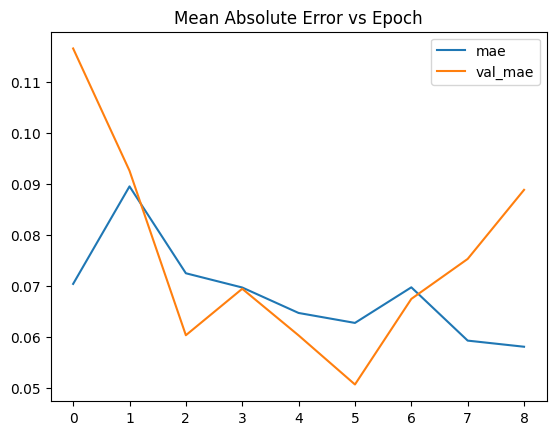

In [29]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

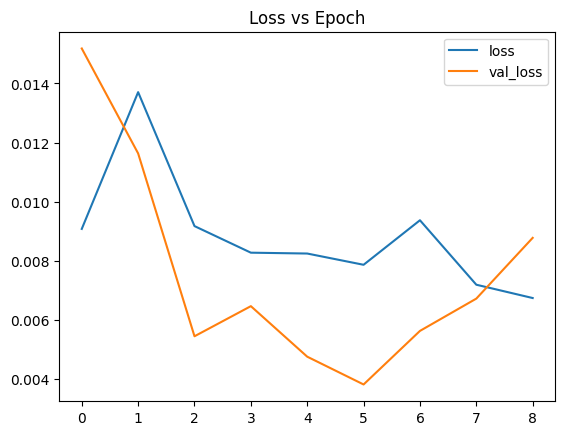

In [30]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

## Evaluation

In [31]:
df.index.max(), df.loc[df.index.max()].shape

(Timestamp('2021-11-05 00:00:00'), (5,))

In [32]:
# Predict all 5 columns for the 10 business days between 11/08/2021 and 11/19/2021
pred_existing = 20
range = pd.bdate_range(start=df.index.max() - pd.tseries.offsets.BDay(pred_existing), end="2021-11-19")
range

DatetimeIndex(['2021-10-08', '2021-10-11', '2021-10-12', '2021-10-13',
               '2021-10-14', '2021-10-15', '2021-10-18', '2021-10-19',
               '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-25',
               '2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29',
               '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04',
               '2021-11-05', '2021-11-08', '2021-11-09', '2021-11-10',
               '2021-11-11', '2021-11-12', '2021-11-15', '2021-11-16',
               '2021-11-17', '2021-11-18', '2021-11-19'],
              dtype='datetime64[ns]', freq='B')

In [33]:
existing_range = range[:pred_existing + 1]

In [34]:
def inverse_scale(predictions):
    prices_scaled = predictions[:, :4]
    volume_scaled = predictions[:, 4:]

    prices_unscaled = scaler.inverse_transform(prices_scaled)
    volume_unscaled = volume_scaler.inverse_transform(volume_scaled)

    # concatenate back into a single array (num_steps, 5)
    unscaled = np.concatenate([prices_unscaled, volume_unscaled], axis=1)
    return unscaled

In [35]:
def predict_range(model, last_window, dates):
  predictions = []
  last_window = np.expand_dims(last_window, axis=0)

  for _ in dates:
    pred = model.predict(last_window).astype(np.float64)
    predictions.append(pred[0])
    pred = np.expand_dims(pred, axis=1)  # Shape: (1, 1, features)
    last_window = np.concatenate([last_window[:, 1:, :], pred], axis=1)  # Still (1, 20, 5)

  return np.array(predictions)

print(normalized[-(timesteps + pred_existing + 1): -(pred_existing + 1)].dtypes)
predictions = inverse_scale(predict_range(simple, normalized[-(timesteps + pred_existing + 1): -(pred_existing + 1)].values, range))

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [36]:
def plot_predictions(dates, pred, feature_names):
  for i, feature in enumerate(feature_names):
    plt.figure(figsize=(10, 5))
    plt.plot(dates, pred[:, i], label=f'Predicted {feature}')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'Stock {feature} Prediction')
    plt.legend()
    plt.show()

In [37]:
predictions.dtype

dtype('float64')

In [43]:
predictions.shape

(31, 5)

In [38]:
print(features)

['Open', 'High', 'Low', 'Close', 'Volume']


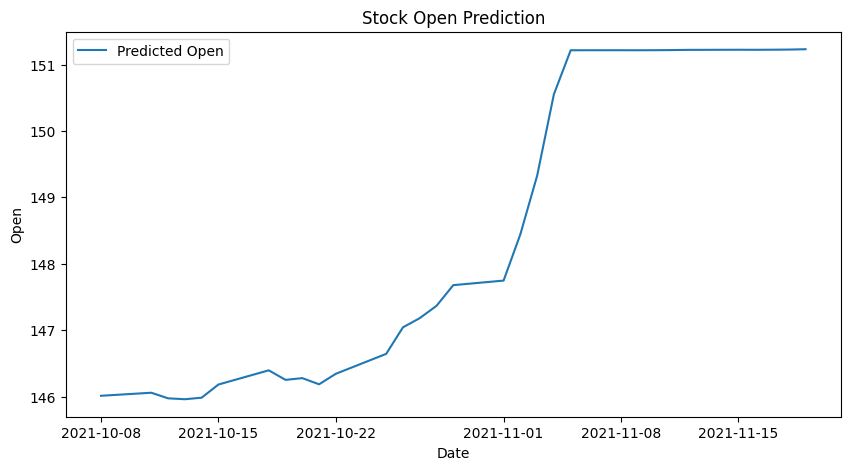

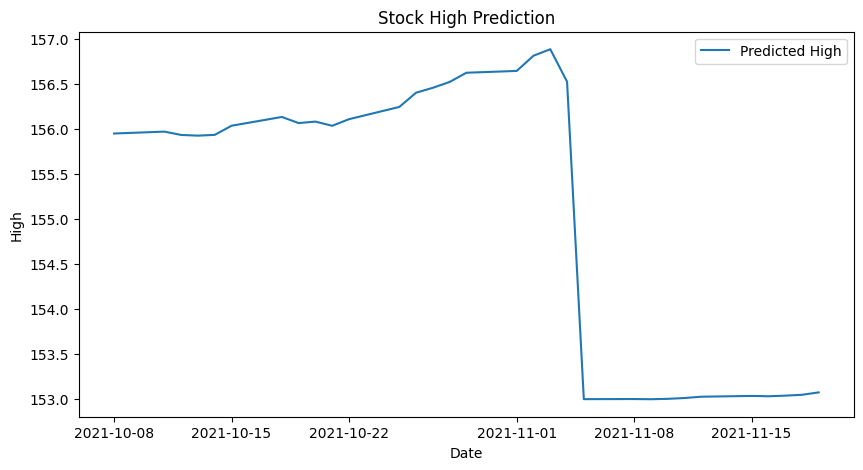

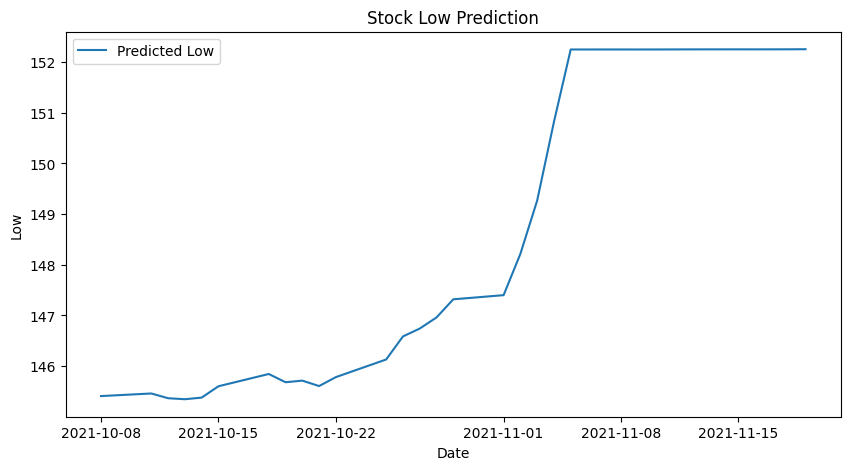

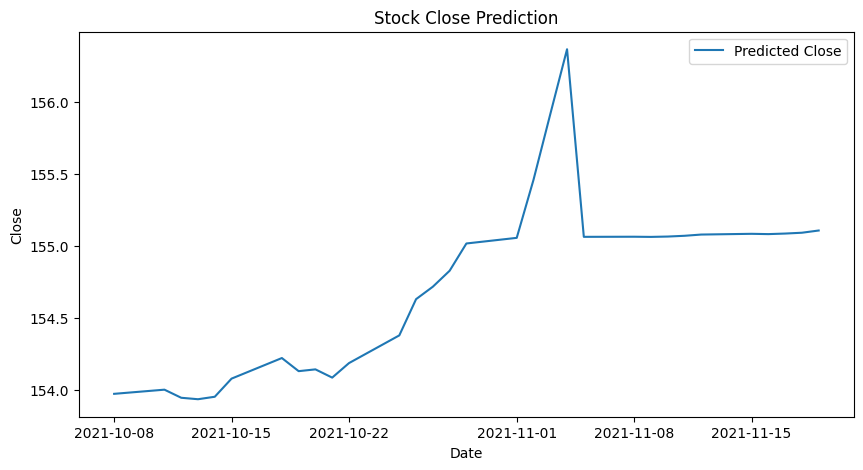

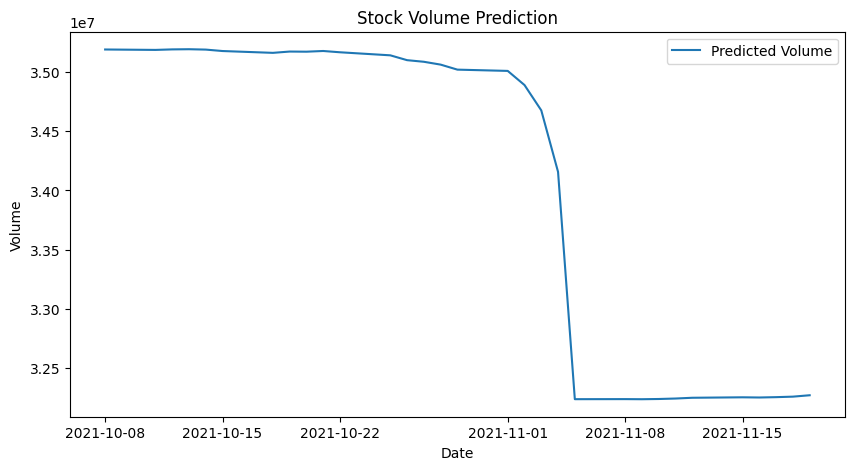

In [39]:
plot_predictions(range, predictions, features)

In [40]:
df.loc[df.idxmax()]

,Open,High,Low,Close,Volume
Date,,,,,
2021-11-05,338.510010,338.790009,334.420013,336.059998,22564000
2021-11-05,338.510010,338.790009,334.420013,336.059998,22564000
2021-11-05,338.510010,338.790009,334.420013,336.059998,22564000
2021-11-04,332.890015,336.540009,329.510010,336.440002,23992200
2018-12-21,101.629997,103.000000,97.459999,98.230003,111242100


In [41]:
inverse_scale(predictions[0:, :])

array([[4.09824779e+04, 4.36794912e+04, 4.03557471e+04, 4.29124718e+04,
        3.65364368e+15],
       [4.09952795e+04, 4.36853484e+04, 4.03699801e+04, 4.29205147e+04,
        3.65328008e+15],
       [4.09716851e+04, 4.36749725e+04, 4.03440090e+04, 4.29048628e+04,
        3.65372976e+15],
       [4.09679298e+04, 4.36728553e+04, 4.03385611e+04, 4.29020602e+04,
        3.65388105e+15],
       [4.09744149e+04, 4.36752849e+04, 4.03473601e+04, 4.29068389e+04,
        3.65355117e+15],
       [4.10299617e+04, 4.37036893e+04, 4.04093970e+04, 4.29418573e+04,
        3.65229173e+15],
       [4.10899052e+04, 4.37309557e+04, 4.04765612e+04, 4.29816359e+04,
        3.65069180e+15],
       [4.10496322e+04, 4.37119667e+04, 4.04314677e+04, 4.29562834e+04,
        3.65183208e+15],
       [4.10569788e+04, 4.37165414e+04, 4.04402758e+04, 4.29597416e+04,
        3.65171002e+15],
       [4.10309122e+04, 4.37035074e+04, 4.04105484e+04, 4.29438080e+04,
        3.65232577e+15],
       [4.10753056e+04, 4.3724

In [42]:
!jupyter nbconvert msft_prediction.ipynb --to html

[NbConvertApp] Converting notebook msft_prediction.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 846622 bytes to msft_prediction.html
